### Load graph

In [5]:
import numpy as np
import os, sys
sys.path.insert(0, "../src/")
from data_component import DataComponent
import time
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
from abc import ABC, abstractmethod
import numpy as np


class InformationDiffusionComponent(ABC):
    @abstractmethod
    def propagate_message(self, message, node_id):
        raise NotImplementedError()

    @abstractmethod
    def receive_message(self, message, node_id):
        raise NotImplementedError()


class BoundedConfidenceDiffusionComponent(InformationDiffusionComponent):
    def __init__(self, data_component, epsilon=0.2, mu=0.5, is_multishot=False, epsilon_backfire=np.inf):
        """epsilon: float : higher epsilon corresponds to higher user bound, hence higher possibility to update opinion in the common direction
           epsilon_backfire: float : higher epsilon_backfire corresponds to higher user backfire bound, hence lower possibility to update opinion in the opposite direction
        """
        self.data_component = data_component
        self.epsilon = epsilon
        self.mu = mu
        self.is_multishot = is_multishot
        self.epsilon_backfire = epsilon_backfire

    def get_opinions(self):
        return self.data_component.get_opinions()

    def get_opinion_mean(self):
        return self.data_component.get_opinion_mean()

    def propagate_message(self, message, node_id, susceptible_pool=None):
        if susceptible_pool is None:
            # initialize a pool of susceptible nodes
            susceptible_pool = list(range(self.data_component.get_num_nodes()))
            susceptible_pool = set(susceptible_pool)
            susceptible_pool.remove(node_id)
        # init propagation
        opinion_shift_tot = 0
        num_activated_users = 0

        activated_users = set()
        
        queue = set(self.data_component.get_neighbors(node_id)).intersection(susceptible_pool)
        while len(queue) > 0:
            neighbor_id = queue.pop()
            # exclude the node from the set of susceptible
            susceptible_pool.discard(neighbor_id)
            # send the message to the node
            activated, opinion_shift = self.receive_message(message, neighbor_id)
            # if the node activated on the message, the node will propagate the message to its neighbors
            if activated:
                activated_users.add(neighbor_id) # DEBUG!!!
                # add neighbors of neighbor_id to the queue of users who received the message
                queue = queue.union(set(self.data_component.get_neighbors(neighbor_id)).intersection(susceptible_pool))
                opinion_shift_tot += opinion_shift
                num_activated_users += 1
        return opinion_shift_tot, num_activated_users, susceptible_pool, activated_users

    def receive_message(self, message, node_id):
        """Returns a tuple (activated_status: bool, opinion_shift)
        """
        init_opinion = self.data_component.get_opinion(node_id)
        disagreement = message - init_opinion
        opinion_shift = self.mu * disagreement
        if abs(disagreement) < self.epsilon:
            init_opinion += opinion_shift
            activated_status = True
            if self.is_multishot:
                self.data_component.update_opinion(node_id, init_opinion)
            return activated_status, opinion_shift
        elif abs(disagreement) > self.epsilon_backfire:
            init_opinion -= opinion_shift
            activated_status = True
            if self.is_multishot:
                self.data_component.update_opinion(node_id, init_opinion)
            return activated_status, - opinion_shift
        return False, 0

In [3]:
def find_uniform_subset(array_of_tuples, num_elements):
    """array_of_tuples: [(node_id, degree), ..]
    Returns a subset of array_of_tuples with num_elements entries
    selecting values uniformly between degree range 
    """
    
    # Extract the degrees
    degrees = np.array([degree for node_id, degree in array_of_tuples])

    # Step 3: Determine the bins
    bins = np.linspace(degrees.min(), degrees.max(), num_elements + 1)

    # Step 4: Extract one tuple from each bin
    bin_indices = np.digitize(degrees, bins) - 1  # Get the bin index for each degree

    uniform_subset = []
    used_bins = set()

    for index, bin_index in enumerate(bin_indices):
        if bin_index not in used_bins:
            uniform_subset.append(array_of_tuples[index])
            used_bins.add(bin_index)
        if len(uniform_subset) == num_elements:
            break

    return uniform_subset

Loading follow graph ..


Graph loaded  ✅
|V|=7_589 |E|=532_459 node types={'int'}


Text(0.5, 0, 'betweenness')

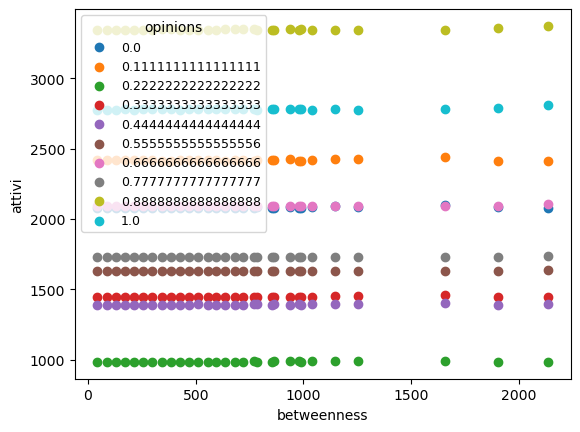

In [9]:
data = DataComponent(real_data="Brexit")
# data = DataComponent(num_nodes=1000, 
#                      modularity=0.9, homophily=0.9, 
#                      avg_deg=5, alpha=1., beta=1.)
G = data.get_graph()
data.pre_compute_neighboring()

_sorted_by_degree = sorted(dict(G.out_degree()).items(), key=lambda x: x[1], reverse=True)
#_sorted_by_degree = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
_filtered_by_degree = [tup for tup in _sorted_by_degree if tup[1] != 0]
sorted_by_degree = find_uniform_subset(_filtered_by_degree, 50)

messages_values = np.linspace(0., 1., 10)

messege2data = {str(message): {'degrees': [], 'rewards': []} for message in messages_values}

for i, (node_id, degree) in enumerate(sorted_by_degree):
    time0 = time.time()
    for message_value in messages_values:
        information_diffusion_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=0.2, mu=0.5)
        __, num_activated_users, __, __ = information_diffusion_model.propagate_message(message=message_value, node_id=node_id)
        messege2data[str(message_value)]['rewards'].append(num_activated_users)
        messege2data[str(message_value)]['degrees'].append(degree)
    delta_time = time.time() - time0
    print(f"{i}/{len(sorted_by_degree)},  estimated time {delta_time*(len(sorted_by_degree)-i-1)/60:.3f} min", end="\r")


for message, data in messege2data.items():
    plt.scatter(data['degrees'], data['rewards'], label=message)
plt.legend(fontsize=9, loc='upper left', title="opinions")
plt.ylabel("attivi")
plt.xlabel("degrees")



---

In [70]:
message_value = 0.5
node_id = 6103
print(node_id, message_value)

data = DataComponent(real_data="Brexit")
G = data.get_graph()
data.pre_compute_neighboring()
information_diffusion_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=0.2, mu=0.5)

__, num_activated_users, __, __ = information_diffusion_model.propagate_message(message=message_value, node_id=node_id)
print(num_activated_users)

6103 0.5
Loading follow graph ..
Graph loaded  ✅
|V|=7_589 |E|=532_459 node types={'int'}
1530


In [69]:
node_id = 6866
print(node_id, message_value)

data = DataComponent(real_data="Brexit")
G = data.get_graph()
data.pre_compute_neighboring()
information_diffusion_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=0.2, mu=0.5)

__, num_activated_users, __, __ = information_diffusion_model.propagate_message(message=message_value, node_id=node_id)
print(num_activated_users)

6866 0.5
Loading follow graph ..
Graph loaded  ✅
|V|=7_589 |E|=532_459 node types={'int'}
1531
